## Imports

In [1]:
# note: must run in virtual environment
import os
import sys
venv_path = os.environ['VIRTUAL_ENV']
sys.path.append(os.path.join(os.environ['VIRTUAL_ENV'], "lib\site-packages"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
%matplotlib inline

## Consts

In [3]:
PROVIDER_AND_ID = "provider_and_id"
CITY = "accident_yishuv_name"
LAT = "latitude"
LONG = "longitude"
X = "x"
Y = "y"

## Load data

In [4]:
csv_path = "involved_markers_hebrew.csv"
data = pd.read_csv(csv_path)

c:\users\asya\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (36,38,40,44,91,93,130,144,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# get only relevant data
filtered = data[[PROVIDER_AND_ID, CITY, LAT, LONG, X, Y]].drop_duplicates()

## Find outliers by zscore

In [170]:
def calc_outliers_for_city(data, zscore_thresh, min_sample_size):
    coords = data[[X, Y]].dropna()
    
    # check if sample size is big enough for the statistic calculation
    if len(coords.drop_duplicates()) <= min_sample_size:
        return []
    
    # calculate zscores for each column
    zscores = stats.zscore(coords, axis = 0)
    zscores = np.nan_to_num(zscores)
    zscores = np.abs(zscores)
    # get indices to outliers
    outliers = np.argwhere(zscores > zscore_thresh)
    outlier_rows = np.unique(outliers[:,0])
    if len(outliers) > 0:
        outlier_rows = data.iloc[outlier_rows]
        return outlier_rows[[PROVIDER_AND_ID, CITY, LAT, LONG, X, Y]]
    return []

def get_outliers_by_z_scores(data, zscore_thresh, min_sample_size = 0):
    res = []
    for city, rows in data.groupby(CITY):
        outliers = calc_outliers_for_city(rows, zscore_thresh, min_sample_size)
        if len(outliers) > 0:
            res.append(outliers)
    return pd.concat(res)

## Visualize effect of different thresholds

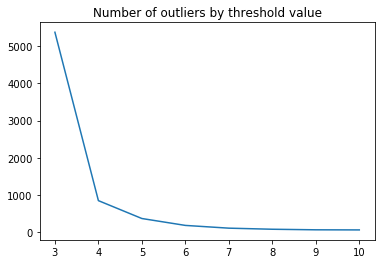

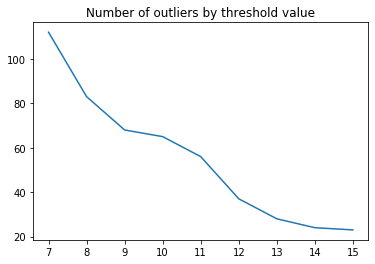

In [107]:
def plot_outliers_by_thresh(low, high):
    threshs = range(low, high+1)
    num_outliers = []
    for i in threshs:
        outliers = get_outliers_by_z_scores(filtered, i)
        num_outliers.append(len(outliers))
    plt.title("Number of outliers by threshold value")
    plt.plot(threshs, num_outliers)
    plt.show()
        
plot_outliers_by_thresh(3,10)
plot_outliers_by_thresh(7,15)

## Pick threshold and minimum sample size

In [166]:
ZSCORE_THRESH = 10
MIN_SAMPLE_SIZE = 100

## Save output

In [171]:
outliers = get_outliers_by_z_scores(filtered, ZSCORE_THRESH, MIN_SAMPLE_SIZE)
outliers.to_csv("outlier_points.csv", header=True, index=False, encoding='utf-8')

## Explore results

In [ ]:
def plot_city(data, city_name):
    city_data = data.loc[data[CITY] == city_name]
    outliers = calc_outliers_for_city(city_data, ZSCORE_THRESH, MIN_SAMPLE_SIZE)
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(15,15))
    ax1.plot(city_data[Y], city_data[X], "o")
    ax2.plot(city_data[LAT], city_data[LONG], "o")
    if len(outliers) > 0:
        ax1.plot(outliers[Y], outliers[X], "ro")
        ax2.plot(outliers[LAT], outliers[LONG], "ro")
    fig.show()
    
plot_city(filtered, "נצרת עילית")